### Importing data and splitting to train and test data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('/content/TractorSales.csv')
print(df)

    Month-Year  Number of Tractor Sold
0        3-Jan                     141
1        3-Feb                     157
2        3-Mar                     185
3        3-Apr                     199
4        3-May                     203
..         ...                     ...
139     14-Aug                     848
140     14-Sep                     640
141     14-Oct                     581
142     14-Nov                     519
143     14-Dec                     605

[144 rows x 2 columns]


<Axes: title={'center': 'Tractor Sales Data'}>

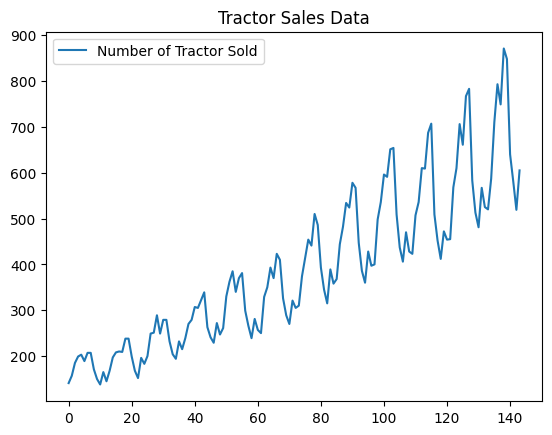

In [3]:
df[['Number of Tractor Sold']].plot(title='Tractor Sales Data')

In [89]:
train_data = df["Number of Tractor Sold"][:124]
test_data = df["Number of Tractor Sold"][124:]

train_data = np.log(train_data)
test_data = test_data.reset_index()

### Holt's Linear Method

In [5]:
def holt_linear(data, alpha, gamma):
  level = [0]*len(data)
  level[0] = data[0]
  trend = [0]*len(data)

  for i in range(1, len(data)):
    level[i] = alpha*data[i] + (1-alpha)*(level[i-1]+trend[i-1])
    trend[i] = gamma*(level[i]-level[i-1]) + (1-gamma)*trend[i-1]

  error = np.sum((data - list(np.array(level)+np.array(trend)))**2)

  return (alpha, gamma, level, trend, error)

In [15]:
min_error = 1000000

for a in tqdm(np.linspace(0, 1, 100)[1:-1]):
  for g in np.linspace(0, 1, 100)[1:-1]:
    (al, ga, l, t, e) = holt_linear(train_data, a, g)
    if e < min_error:
      (alpha, gamma, level, trend, min_error) = (al, ga, l, t, e)

100%|██████████| 98/98 [00:09<00:00, 10.72it/s]


In [16]:
print(alpha, gamma, min_error)

0.98989898989899 0.010101010101010102 0.004408043068317236


In [17]:
linear_forecasts = []

for i in range(1, len(test_data)+1):
  linear_forecasts.append(np.exp(level[-1] + i*trend[-1]))

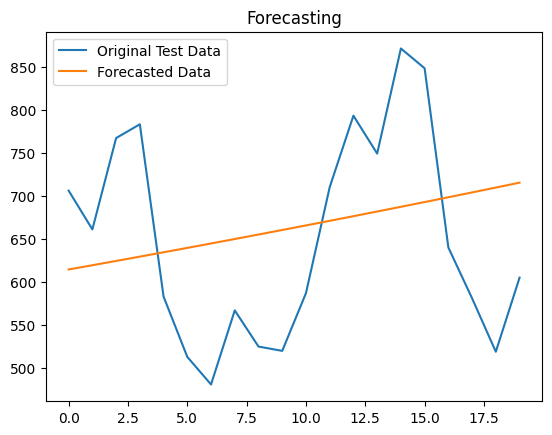

In [90]:
plt.plot(test_data["Number of Tractor Sold"], label = "Original Test Data")
plt.plot(linear_forecasts, label = "Forecasted Data")
plt.title("Forecasting")
plt.legend()
plt.show()

### Winter Holt's Method

In [24]:
def winter_holt(data, alpha, gamma, delta):
  level = [0]*len(data)
  level[0] = data[0]
  trend = [0]*len(data)
  seasonal = [0]*len(data)
  d = 12

  for i in range(1, len(data)):
    if i-d >= 0:
      level[i] = alpha*(data[i]-seasonal[i-d]) + (1-alpha)*(level[i-1]+trend[i-1])
      trend[i] = gamma*(level[i]-level[i-1]) + (1-gamma)*trend[i-1]
      seasonal[i] = delta*(data[i] - level[i]) + (1-delta)*seasonal[i-d]
    else:
      level[i] = alpha*data[i] + (1-alpha)*(level[i-1]+trend[i-1])
      trend[i] = gamma*(level[i]-level[i-1]) + (1-gamma)*trend[i-1]
      seasonal[i] = delta*(data[i] - level[i])

  error = np.sum((data - list((np.array(level)+np.array(trend))*np.array(seasonal)))**2)

  return (alpha, gamma, delta, level, trend, seasonal, error)

In [25]:
min_error = 100000000

for a in tqdm(np.linspace(0, 1, 100)[1:-1]):
  for g in np.linspace(0, 1, 100)[1:-1]:
    for d in np.linspace(0, 1, 100)[1:-1]:
      (al, ga, delt, l, t, s, e) = winter_holt(train_data, a, g, d)
      if e < min_error:
        (alpha, gamma, delta, level, trend, seasonal, min_error) = (al, ga, delt, l, t, s, e)

100%|██████████| 98/98 [22:07<00:00, 13.55s/it]


In [51]:
winter_forecasts = []

for i in range(1, 13):
  winter_forecasts.append(np.exp(level[-1] + i*trend[-1] + seasonal[len(seasonal)-1+i-12]))

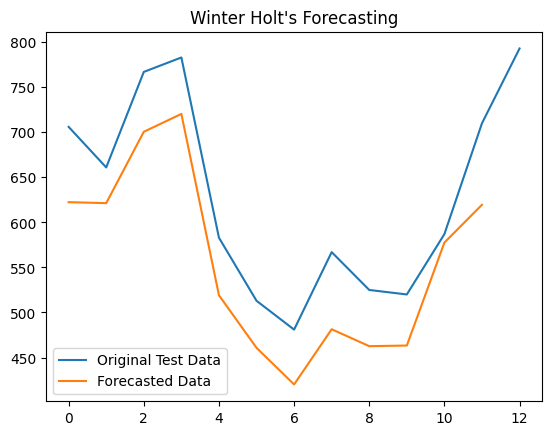

In [70]:
plt.plot(test_data["Number of Tractor Sold"][:13], label = "Original Test Data")
plt.plot(winter_forecasts, label = "Forecasted Data")
plt.title("Winter Holt's Forecasting")
plt.legend()
plt.show()

### Plotting the train data and predictions together

In [92]:
train_data = df["Number of Tractor Sold"][:124]
test_data = df["Number of Tractor Sold"][124:]

In [109]:
linear_preds = pd.Series(linear_forecasts, index = test_data.index)
winter_preds = pd.Series(winter_forecasts, index = test_data[:12].index)

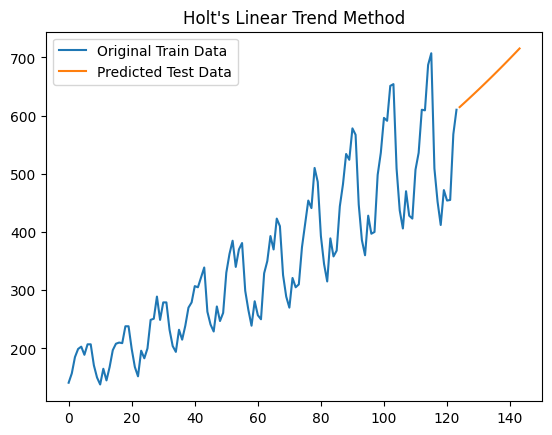

In [112]:
plt.plot(train_data, label = "Original Train Data")
plt.plot(linear_preds, label = "Predicted Test Data")
plt.title("Holt's Linear Trend Method")
plt.legend()
plt.show()

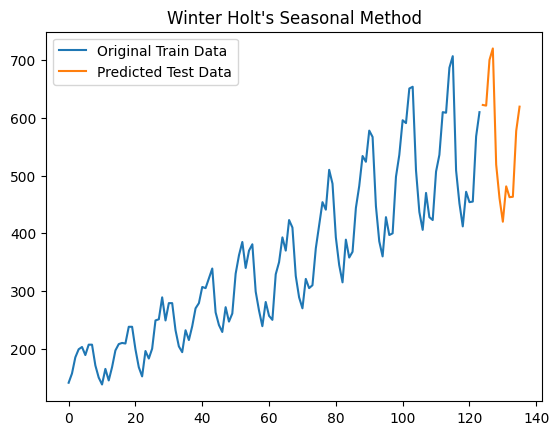

In [113]:
plt.plot(train_data, label = "Original Train Data")
plt.plot(winter_preds, label = "Predicted Test Data")
plt.title("Winter Holt's Seasonal Method")
plt.legend()
plt.show()

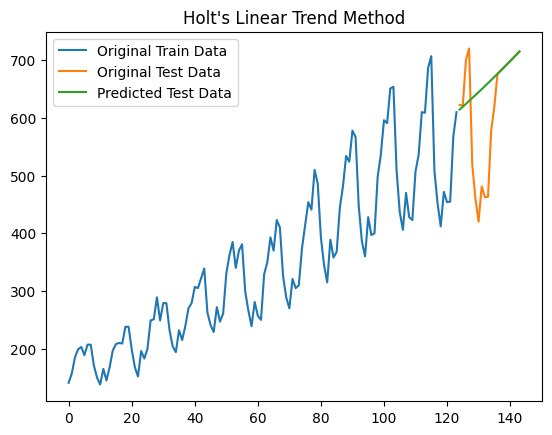

In [110]:
plt.plot(train_data, label = "Original Train Data")
plt.plot(test_data, label = "Original Test Data")
plt.plot(linear_preds, label = "Predicted Test Data")
plt.title("Holt's Linear Trend Method")
plt.legend()
plt.show()

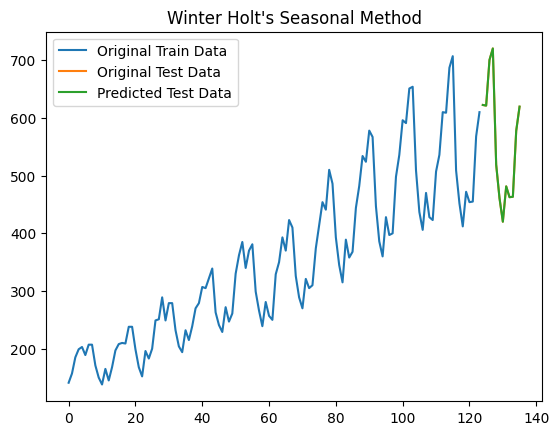

In [111]:
plt.plot(train_data, label = "Original Train Data")
plt.plot(test_data[:12], label = "Original Test Data")
plt.plot(winter_preds, label = "Predicted Test Data")
plt.title("Winter Holt's Seasonal Method")
plt.legend()
plt.show()